# Retail Sales Forecasting Project

This project demonstrates **end-to-end forecasting of daily retail sales** using **SARIMAX** and **Prophet**, including exploratory data analysis, feature engineering, modeling, and evaluation.

---

## 1️⃣ Project Overview

- Objective: Forecast daily sales to improve stock management and support business decisions.
- Scope: Predict sales using historical sales, stock, prices, and temporal features.
- Approach: Time series forecasting with exogenous variables using SARIMAX and Prophet.

---

## 2️⃣ Data Exploration (EDA)

- Visualized **daily sales trends**.
- Compared **stock vs sales** to understand inventory influence.
- Analyzed **price vs sales** relationship.
- Computed **correlation matrix**:

      sales     stock     price
sales 1.000000 0.153659 0.094779
stock 0.153659 1.000000 -0.032604
price 0.094779 -0.032604 1.000000  



**Insights:**
- Weak correlations with stock and price.
- Trend, seasonality, and lag features are important for forecasting.

---

## 3️⃣ Feature Engineering

- **Temporal features:** day, month, day of week.
- **Lag features:** sales of previous day (t-1), previous week (t-7), previous 2 weeks (t-14).
- **Rolling mean:** 7-day rolling average to capture trend and weekly patterns.

**Rationale:** Lag features and rolling averages help capture autocorrelation and seasonality in sales.

---

## 4️⃣ Train/Test Split

- 80% of the data for training, 20% for testing.
- Ensures **chronological order** for time series forecasting.

---

## 5️⃣ SARIMAX Model

- Model: SARIMAX with exogenous variables (`stock`, `price`, `sales_lag_1`, `rolling_7`).
- Order (p,d,q): initially tried several combinations; best baseline `(2,0,2)`.
- Forecasted sales and computed **confidence intervals**.
- Predicted values plotted against actual sales for visual evaluation.

**Model choice rationale:** SARIMAX captures both **autoregressive behavior** and **external influences**.

---

## 6️⃣ Evaluation Metrics

- **MSE:** 7340.99  
- **RMSE:** 85.68  
- **MAE:** 64.80  
- **SMAPE:** 49.82%

**Interpretation:**
- Predictions capture trend but miss some peaks and anomalies.
- SMAPE < 50% indicates baseline model is moderately accurate.
- Errors are acceptable for a first attempt; can be improved with more features or tuning.

---

## 7️⃣ Prophet Model (Comparison)

- Prophet provides **alternative baseline** capturing trend and seasonality.
- Useful to compare with SARIMAX.
- Visual inspection confirms Prophet forecasts trends reasonably but may differ on peak days.

---

## 8️⃣ Key Takeaways

1. Lag features and rolling averages are critical for time series forecasting.
2. Current SARIMAX baseline is reasonable (**SMAPE ~50%**).
3. Potential improvements:
   - Add holidays, promotions, events.
   - Tune SARIMAX parameters or try seasonal SARIMAX.
   - Explore ML/DL models: XGBoost, LSTM, etc.
4. Pipeline is ready for **production-ready deployment**:
   - Train/test split, predictions, metrics.
   - Forecast intervals for uncertainty quantification.

---

## 9️⃣ Next Steps for Production & Optimization

- Automate **feature engineering** and **forecasting pipeline**.
- Monitor performance in production (drift detection, retraining).
- Collaborate with business teams to **translate forecasts into actionable recommendations** (replenishment, stock alerts).


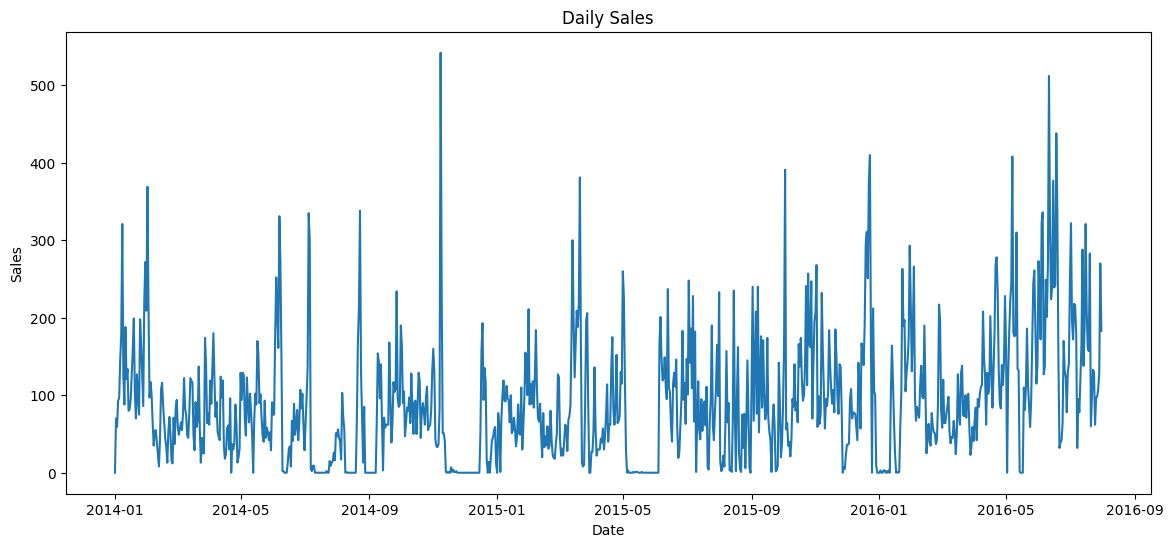

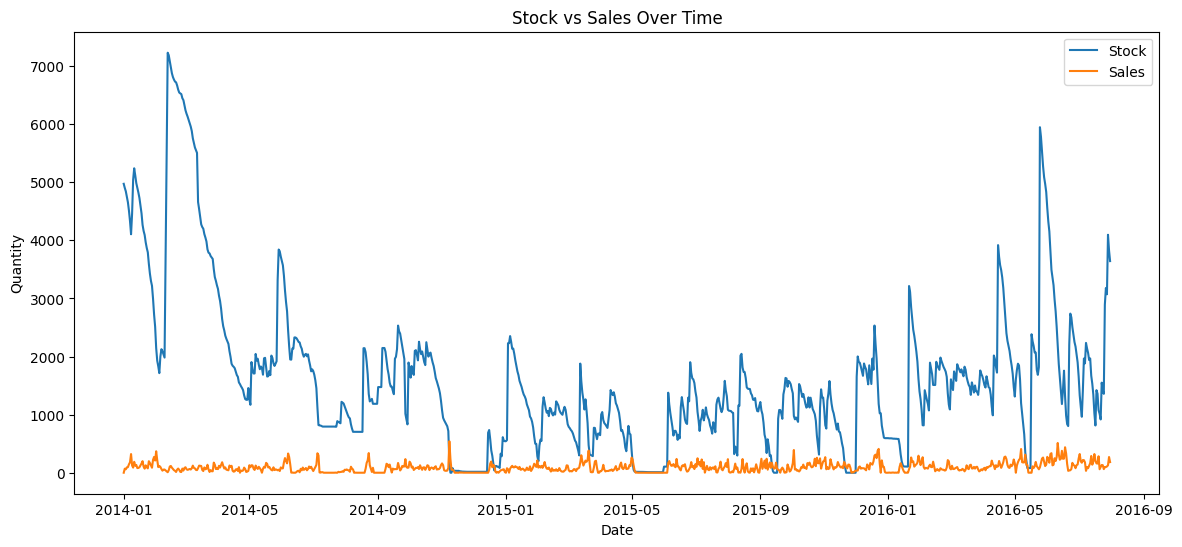

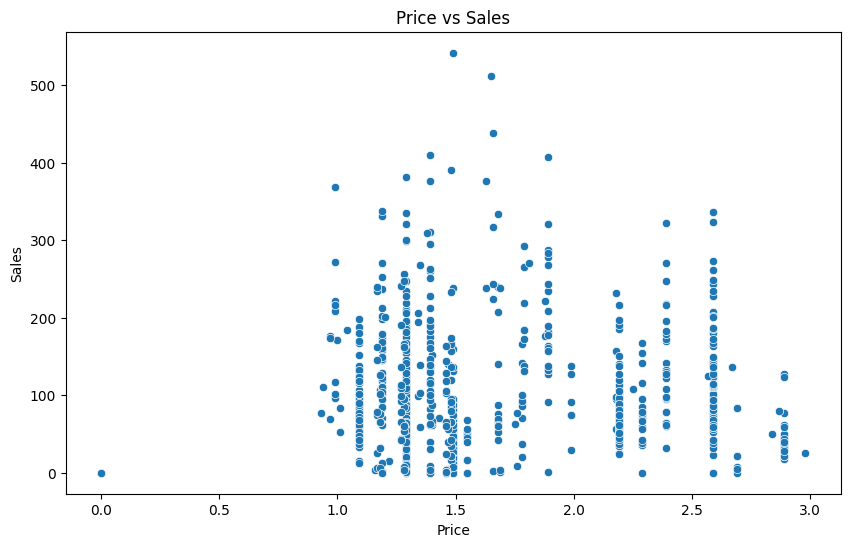

Correlation matrix:
          sales     stock     price
sales  1.000000  0.153659  0.094779
stock  0.153659  1.000000 -0.032604
price  0.094779 -0.032604  1.000000


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


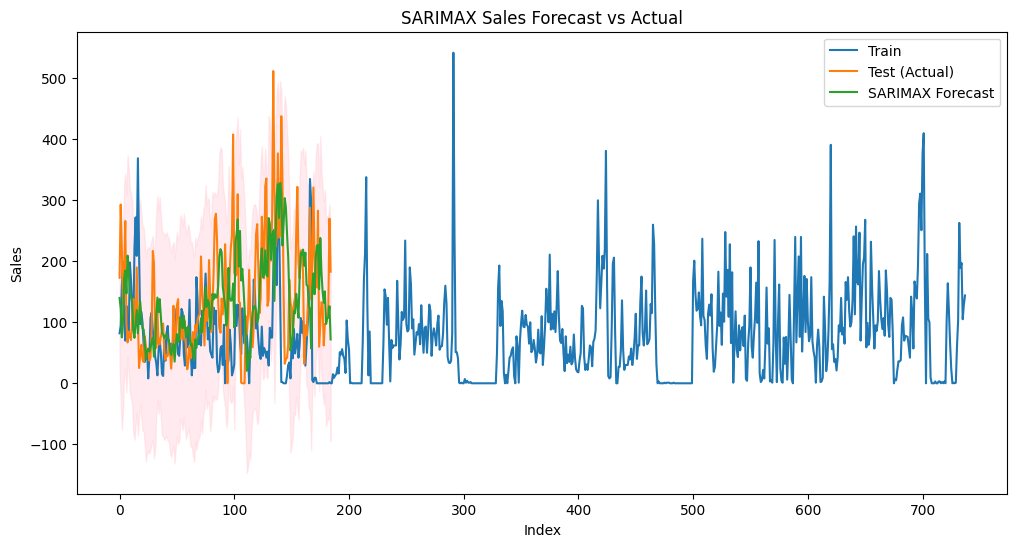

MSE: 7340.99
RMSE: 85.68
MAE: 64.80
SMAPE: 49.82%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


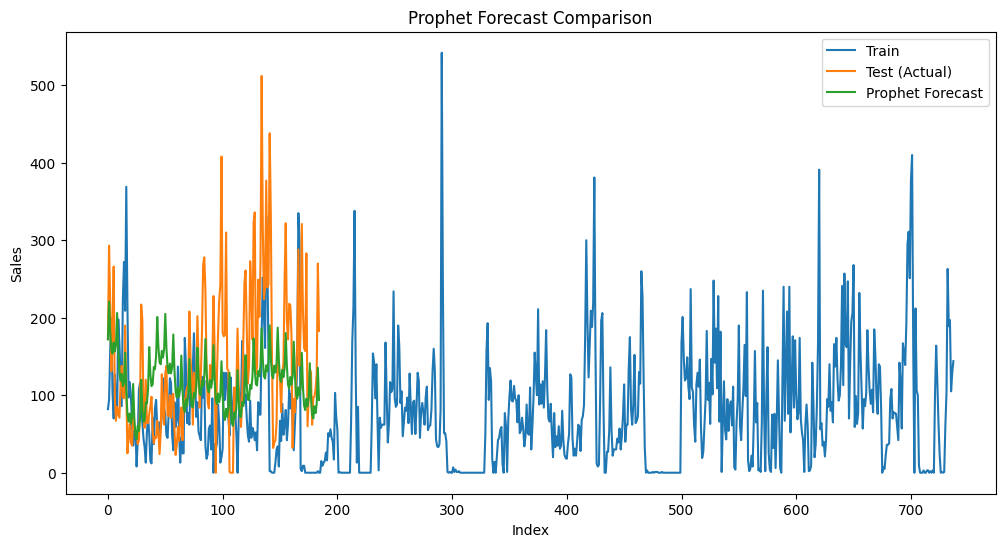

In [2]:
# ===============================
# 1️⃣ IMPORTS
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

# ===============================
# 2️⃣ LOAD DATA
# ===============================
df = pd.read_csv("mock_kaggle.csv")

# Rename columns for clarity
df.columns = ["date", "sales", "stock", "price"]

# Convert 'date' column to datetime type
df["date"] = pd.to_datetime(df["date"])

# Sort data by date
df = df.sort_values("date").reset_index(drop=True)

# Check the first few rows
df.head()

# ===============================
# 3️⃣ EXPLORATORY DATA ANALYSIS (EDA)
# ===============================
# Plot daily sales
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x="date", y="sales")
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Plot stock vs sales
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x="date", y="stock", label="Stock")
sns.lineplot(data=df, x="date", y="sales", label="Sales")
plt.title("Stock vs Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()

# Price vs Sales
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="price", y="sales")
plt.title("Price vs Sales")
plt.xlabel("Price")
plt.ylabel("Sales")
plt.show()

# Correlation
print("Correlation matrix:")
print(df[["sales","stock","price"]].corr())

# ===============================
# 4️⃣ FEATURE ENGINEERING
# ===============================
# Temporal features
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek

# Lag features
df["sales_lag_1"] = df["sales"].shift(1)
df["sales_lag_7"] = df["sales"].shift(7)
df["sales_lag_14"] = df["sales"].shift(14)

# Rolling mean (trend / seasonality)
df["rolling_7"] = df["sales"].rolling(window=7).mean()

# Drop NA values created by lagging
df = df.dropna().reset_index(drop=True)

# ===============================
# 5️⃣ TRAIN / TEST SPLIT
# ===============================
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].reset_index(drop=True)
test = df.iloc[train_size:].reset_index(drop=True)

# ===============================
# 6️⃣ MODELING: SARIMAX
# ===============================
# Define exogenous variables
exog_vars = ["stock", "price", "sales_lag_1", "rolling_7"]

# Create SARIMAX model
model = SARIMAX(
    train["sales"],          # target variable
    exog=train[exog_vars],   # exogenous features
    order=(2,0,2),           # (p,d,q)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
model_fit = model.fit(disp=False)

# ===============================
# 7️⃣ PREDICTION
# ===============================
n_forecast = len(test)
forecast = model_fit.get_forecast(steps=n_forecast, exog=test[exog_vars])
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# ===============================
# 8️⃣ VISUALIZATION OF PREDICTIONS
# ===============================
plt.figure(figsize=(12,6))
plt.plot(train.index, train["sales"], label="Train")
plt.plot(test.index, test["sales"], label="Test (Actual)")
plt.plot(test.index, pred, label="SARIMAX Forecast")
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title("SARIMAX Sales Forecast vs Actual")
plt.xlabel("Index")
plt.ylabel("Sales")
plt.legend()
plt.show()

# ===============================
# 9️⃣ EVALUATION
# ===============================
mse = mean_squared_error(test["sales"], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test["sales"], pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# SMAPE function
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_value = smape(test["sales"].values, pred)
print(f"SMAPE: {smape_value:.2f}%")

# ===============================
# 10️⃣ OPTIONAL: COMPARISON WITH PROPHET
# ===============================
prophet_df = df[["date","sales"]].rename(columns={"date":"ds","sales":"y"})
m = Prophet()
m.fit(prophet_df[:len(train)])
future = prophet_df[len(train):]
forecast_prophet = m.predict(future)

plt.figure(figsize=(12,6))
plt.plot(train.index, train["sales"], label="Train")
plt.plot(test.index, test["sales"], label="Test (Actual)")
plt.plot(test.index, forecast_prophet["yhat"].values, label="Prophet Forecast")
plt.title("Prophet Forecast Comparison")
plt.xlabel("Index")
plt.ylabel("Sales")
plt.legend()
plt.show()
